In [1]:
import csv
import copy
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

source = "en"   
target = ["id", "ms", "fr", "ca", "es",  "pt",  "nl", "ru", "zh",  "de", "da", "el", "fi", "ko", "lt", "mk", "no", "pl", "ro", "sv", "uk", "it"]
languages = [ "zh","ko", "id", "ms",  "en", "nl", "de", "da",  "no", "sv", "fi", "lt",  "pl", "ru", "uk", "mk", "el",  "ro",  "it", "fr", "ca",  "es", "pt",  ]
keyword_languages = ["id", "ms", "fr", "es",  "pt",  "nl", "en", "ru", "zh"]

language_names = {"en": "English", "ms": "Malay", "pt":"Portuguese", "fr": "French", "id": "Indonesian", 
                  "nl": "Dutch", "es": "Spanish","zh":"Chinese", "ru": "Russian", "ca": "Catalan", "de": "German", "da": "Danish", 
                  "el": "Greek", "fi": "Finnish", "it": "Italian", "ko": "Korean", "lt": "Lithuanian", "mk": "Macedonian", "no": "Norwegian", 
                  "pl": "Polish", "ro": "Romanian", "sv": "Swedish", "uk": "Ukrainian"}

In [2]:
from src.util import load_strong_translations, load_worldlex_data, expand_chinese_characters
from src.word_mapping import calculate_frequency, get_wordlist

# worldlex frequency
freq = load_worldlex_data(relative_frequency=False, average=False, source=["blog", "twitter"], languages=languages)

# conversion to simplified chinese from https://github.com/BYVoid/OpenCC
freq["zh"] = expand_chinese_characters(freq["zh"], convert="key", count_values=True)


#### Mapping words to English lemma

In [3]:
lemma_strong_translations = load_strong_translations(languages, folder_path="strong-translations/lemma-strong-translations-0.2", source="en_lemma")

# aggregate frequency based on lemmatized strong translations
tr_freq = calculate_frequency(freq, lemma_strong_translations, languages, source="en_lemma")
# final list of words (where words appear in > 1 languages)
wordlist = get_wordlist(tr_freq, languages) 

In [4]:
from src.statistics import final_score, rank_keyword_score, get_alphas, get_n, proportion_score, frequency_score,\
rank_keyword_by_freq_score

# from src.statistics import get_n, frequency_score, rank_keyword_by_freq_score, rank_keyword_score

# proposed method of bayesian likelihood with Dirichlet prior, then ranked by language
smoothing_param = 1
n = get_n(freq)
alphas = get_alphas(tr_freq, wordlist, smoothing_param)
bayesian_score = final_score(tr_freq, alphas, wordlist, n)

# rank by s_w, word with S_w and argmax s_w
bayesian_rank, bayesian_rank_keyword_score, _ = rank_keyword_score(wordlist, languages, bayesian_score) 

# baseline method measures difference in proportions
prop_score = proportion_score(tr_freq, wordlist, n)
prop_rank, prop_rank_keyword_score, _  = rank_keyword_score(wordlist, languages, prop_score)

# baseline method measures difference in raw frequency, rank by ascending and descending 
freq_score = frequency_score(wordlist, languages, tr_freq, n)
asc_rank, asc_rank_keyword_score = rank_keyword_by_freq_score(wordlist, languages, freq_score, descending=False)
des_rank, des_rank_keyword_score = rank_keyword_by_freq_score(wordlist, languages, freq_score, descending=True)
clf_ranks = {"bayesian": bayesian_rank, "proportion": prop_rank, "descending": des_rank}

In [5]:
from src.keywords import  load_and_translate_keywords
# load all keywords

cultural_keywords, concept_words_language, expected_keywords, all_keywords_en, available_keywords,\
internal_keywords, external_keywords = load_and_translate_keywords(lemma_strong_translations, keyword_languages, "en_lemma", wordlist)

In [6]:
from src.statistics import sort_tuple_score, get_recall_at_k

bayesian_tuple = sort_tuple_score(bayesian_score)
prop_tuple = sort_tuple_score(prop_score)
des_tuple = sort_tuple_score(freq_score)
clf_tuple = {"bayesian": bayesian_tuple, "proportion": prop_tuple, "descending": des_tuple}

clf_tuple_rank = {met: {tup: i+1 for i, tup in enumerate(tuples)} for met, tuples in clf_tuple.items()}

clf_recall = {clf: get_recall_at_k(available_keywords, rank) for clf, rank in clf_tuple.items()}

#### plot

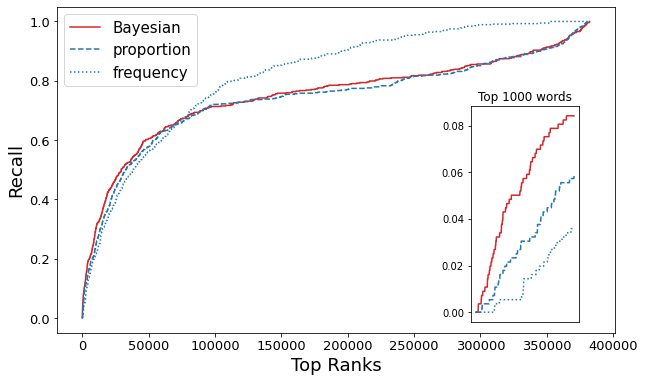

In [7]:
from src.visualisation import compare_recall_ranks_all_methods_inset
import warnings
warnings.filterwarnings('ignore')

compare_recall_ranks_all_methods_inset(clf_recall, method_style_dict={"bayesian": "r-", "proportion":"k--", "descending": "k:"},
                                       method_label_dict={"bayesian": "Bayesian", "proportion":"proportion", "descending": "frequency"},
                                       method_colour_dict={"bayesian": "tab:red", "proportion":"tab:blue", "ascending": "tab:blue", "descending": "tab:blue"},
                                       top_n=len(clf_recall['bayesian']), inset_range=[0, 1000, 0.00, 0.15])

#### Independence test

In [9]:
from src.evaluation import sample_wordlist_with_replacement, expand_tr_freq, expand_keywords, evaluate_by_vocab
from src.statistics import random_baseline

nsamples = 100
wordlist_clf_eval, wordlist_rank_eval = evaluate_by_vocab(wordlist, tr_freq, lemma_strong_translations, n=n, smoothing_param=smoothing_param, 
                                                          npartitions=nsamples, keyword_languages=keyword_languages)

wordlist_rank_eval_exp = [{method: {"all": {"sum": recall}} for method, recall in rank_eval.items()} for rank_eval in wordlist_rank_eval ]

In [11]:
from src.evaluation import pvalue_by_wordlist, sample_mean_stddev
rank_eval_idx=1000
metric_names={"clf-all-mean": "mean keyword classification", "clf-all-recall": "correct keyword classification", "rank-all-recall":f"recall@{rank_eval_idx}"}

method_pairs = [("bayesian", "proportion"), ("bayesian", "descending"), ("proportion", "descending")]
clf_rank_pair_pvalue = pvalue_by_wordlist(method_pairs, wordlist_clf_eval, wordlist_rank_eval_exp, metrics=["rank"], rank_eval_idx=rank_eval_idx)

random_method_pairs = ("bayesian", "random"), ("proportion", "random"), ("descending", "random")
clf_rank_pair_pvalue_random = pvalue_by_wordlist(random_method_pairs, wordlist_clf_eval, wordlist_rank_eval_exp, metrics=["clf"], rank_eval_idx=rank_eval_idx)

mean_stddev = {}
for met in ["bayesian", "proportion", "descending", "random"]:
    if met == "random":
        mean_stddev[met] = sample_mean_stddev(met, wordlist_clf_eval, wordlist_rank_eval_exp, metrics=["clf"], rank_eval_idx=rank_eval_idx) 
    else:
        mean_stddev[met] = sample_mean_stddev(met, wordlist_clf_eval, wordlist_rank_eval_exp, metrics=["clf", "rank"], rank_eval_idx=rank_eval_idx) 
            

In [510]:
longest = max([len(name) for name in metric_names.values()])
for met, m_std in mean_stddev.items():
    print(f"###### {met.upper()} ######")
    for metric, mean in m_std["mean"].items():
        print(f"{metric_names.get(metric, metric)}{' '*(longest-len(metric_names.get(metric, metric)))}: mean={mean}, std={m_std['stddev'][metric]}")
    print()

###### BAYESIAN ######
mean keyword classification   : mean=5.025579225574105, std=0.227984700156471
correct keyword classification: mean=0.3315776629002263, std=0.020138850621550006
recall@1000                   : mean=0.08395431688711749, std=0.012926076963315759

###### PROPORTION ######
mean keyword classification   : mean=4.763656079721319, std=0.20405891955956032
correct keyword classification: mean=0.3034823273887047, std=0.020367836370092204
recall@1000                   : mean=0.05829599925772568, std=0.010746195618072192

###### DESCENDING ######
mean keyword classification   : mean=4.763656079721319, std=0.20405891955956032
correct keyword classification: mean=0.3034823273887047, std=0.020367836370092204
recall@1000                   : mean=0.03570936626048809, std=0.008501186340026022

###### RANDOM ######
mean keyword classification   : mean=9.97074014865845, std=0.26838648948708144
correct keyword classification: mean=0.06384084290294649, std=0.010779696961462732



In [511]:

print(f"p-value over {nsamples} repeated samples for comparison in classification \n")
for clf_pair, result in clf_rank_pair_pvalue_random.items():
    print(f"##### {clf_pair.split('-')[0].upper()} vs. {clf_pair.split('-')[1].upper()} #####")
    for metric, res in result.items():
        try:
            print(f"{metric_names.get(metric, metric)}{' '*(longest-len(metric_names.get(metric, metric)))}: {res.statistic}, pval={res.pvalue}")
        except:
            print(f"{metric_names.get(metric, metric)}{' '*(longest-len(metric_names.get(metric, metric)))}: {res}")
    print()

print(f"p-value over {nsamples} repeated samples for comparison in ranks \n")
for clf_pair, result in clf_rank_pair_pvalue.items():
    print(f"##### {clf_pair.split('-')[0].upper()} vs. {clf_pair.split('-')[1].upper()} #####")
    for metric, res in result.items():
        try:
            print(f"{metric_names.get(metric, metric)}{' '*(longest-len(metric_names.get(metric, metric)))}: {res.statistic}, pval={res.pvalue}")
        except:
            print(f"{metric_names.get(metric, metric)}{' '*(longest-len(metric_names.get(metric, metric)))}: {res}")
    print()


p-value over 100 repeated samples for comparison in classification 

##### BAYESIAN vs. RANDOM #####
mean keyword classification   : 1.0
correct keyword classification: 0.0

##### PROPORTION vs. RANDOM #####
mean keyword classification   : 1.0
correct keyword classification: 0.0

##### DESCENDING vs. RANDOM #####
mean keyword classification   : 1.0
correct keyword classification: 0.0

p-value over 100 repeated samples for comparison in ranks 

##### BAYESIAN vs. PROPORTION #####
recall@1000                   : 0.0

##### BAYESIAN vs. DESCENDING #####
recall@1000                   : 0.0

##### PROPORTION vs. DESCENDING #####
recall@1000                   : 0.0



In [13]:
wordlist_rank_eval_steps = {method: np.stack([np.array(reval[method]["all"]["sum"]) for reval in wordlist_rank_eval_exp]).T 
                            for method in wordlist_rank_eval_exp[0].keys()}   # (steps, samples)
rank_mean_estimate = {method: np.mean(wordlist_rank_eval_steps[method], axis=1) for method in wordlist_rank_eval_exp[0].keys()}
rank_stde_estimate = {method: np.std(wordlist_rank_eval_steps[method], axis=1)/np.sqrt(nsamples) for method in wordlist_rank_eval_exp[0].keys()}

error_estimate = {method: (rank_mean_estimate[method]-rank_stde_estimate[method], rank_mean_estimate[method]+rank_stde_estimate[method]) 
                  for method in wordlist_rank_eval[0].keys()}


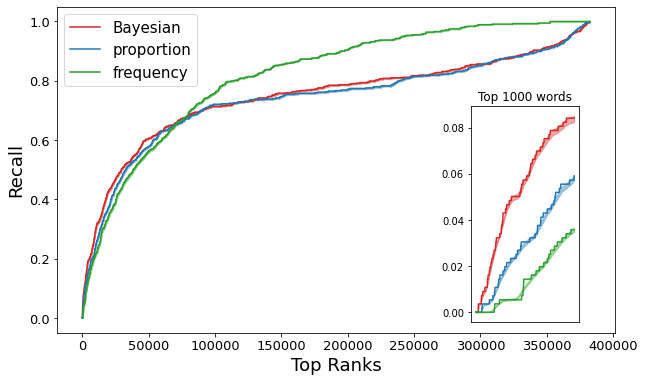

In [496]:
top_10_percent = round(len(wordlist) * 0.1)
zoomed_axins = compare_recall_ranks_all_methods_inset(clf_recall, method_style_dict={"bayesian": "r-", "proportion":"k-", "descending": "k-"},
                                       method_label_dict={"bayesian": "Bayesian", "proportion":"proportion", "descending": "frequency"},
                                       method_colour_dict={"bayesian": "tab:red", "proportion":"tab:blue", "descending": "tab:green"},
                                       top_n=len(wordlist), inset_range=[0, 1000, 0.00, 0.15],
                                       fill_between=error_estimate)
plt.savefig("figures/recall_tuple_inset_stderror.pdf", format="pdf", bbox_inches='tight')

#### Classification

In [455]:
from src.statistics import random_baseline, always_english_baseline, majority_baseline_non_english
# other baselines

# rank languages in random
random_rank = random_baseline(wordlist, tr_freq, languages) 
# rank english as 1 if the word exists in english corpus, rank randomly otherwise
always_en_rank = always_english_baseline(wordlist, tr_freq, languages) 
# rank the majority non-english language as 1 if word exists in the language, otherwise, rank randomly
majority_non_en_rank = majority_baseline_non_english(wordlist, tr_freq, languages, available_keywords)

clf_ranks["random"] = random_rank
clf_ranks["always_en"] = always_en_rank
clf_ranks["majority_non_en"] = majority_non_en_rank

In [495]:
from collections import Counter
def get_best_possible_mean_rank(lang_keywords):
    all_kws = [kw for kws in lang_keywords.values() for kw in kws]
    return np.mean([i+1 for kw, count in Counter(all_kws).items() for i in range(count)])

print(f"Best possible mean rank of unrevealing keywords: {get_best_possible_mean_rank(internal_keywords)}")
print(f"Best possible mean rank of revealing keywords: {get_best_possible_mean_rank(external_keywords)}")
print(f"Best possible mean rank of all keywords: {get_best_possible_mean_rank(available_keywords)}")

Best possible mean rank of unrevealing keywords: 1.1324200913242009
Best possible mean rank of revealing keywords: 1.1651917404129795
Best possible mean rank of all keywords: 1.1523297491039426


In [456]:
from src.evaluation import evaluate_keyword_classifications
# internal = revealing keywords; external = unrevealing keywords, descending = frequency  
evaluate_keyword_classifications(clf_ranks, external_keywords, internal_keywords, available_keywords)


method         : recall, mean rank (ext/int/overall)
bayesian       : (0.42/0.19/0.33), (4.62/5.69/5.04)
proportion     : (0.37/0.20/0.30), (4.35/5.42/4.77)
descending     : (0.37/0.20/0.30), (4.35/5.42/4.77)
random         : (0.06/0.05/0.06), (10.00/9.58/9.84)
always_en      : (0.35/0.57/0.43), (7.55/4.70/6.43)
majority_non_en: (0.15/0.12/0.14), (9.63/9.31/9.50)


In [457]:
from src.evaluation import evaluate_by_keyword_categories_language

evaluation_by_lang = evaluate_by_keyword_categories_language(external_keywords, internal_keywords, available_keywords,
                                            language_names, clf_ranks["bayesian"], verbose=True, decimal_place=2)

Recall of rank 1 keywords across languages: 
language, external, internal, overall
en: 0.37, 0.2, 0.28
es: 0.5, 0.22, 0.41
fr: 0.53, 0.0, 0.49
id: 0.35, 1.0, 0.39
nl: 0.25, 1.0, 0.29
pt: 0.52, 0.27, 0.42
ms: 0.4, 0.04, 0.14
zh: 0.34, 0.25, 0.32
ru: 0.48, 0.09, 0.37

(mean, std) of keyword ranks across languages: 
language, external, internal, overall
en: (3.91,4.16), (6.51,5.66), (5.25,5.15)
es: (3.44,4.37), (4.09,2.86), (3.64,3.95)
fr: (3.27,3.53), (8.5,5.2), (3.66,3.87)
id: (10.18,8.68), (1.0,n/a), (9.67,8.69)
nl: (6.44,5.69), (1.0,n/a), (6.12,5.67)
pt: (3.9,5.05), (4.87,4.79), (4.31,4.9)
ms: (2.4,2.12), (3.67,2.67), (3.32,2.57)
zh: (8.81,8.36), (5.83,6.01), (8.0,7.84)
ru: (4.15,5.01), (5.55,4.13), (4.55,4.76)


#### Language pair similarities

In [10]:
from src.evaluation import pearson_correlation
def correlation_by_language_pairs(languages, word_ranks):
    corr = {lang: {} for lang in languages}
    for i, lang1 in enumerate(languages):
        for lang2 in languages[i:]:
            pearsc = pearson_correlation(word_ranks[lang1], word_ranks[lang2], label=None, verbose=False, outer=False)
            corr[lang1][lang2] = pearsc
            corr[lang2][lang1] = pearsc
    return corr

rank_correlation_by_language = correlation_by_language_pairs(languages, bayesian_score)

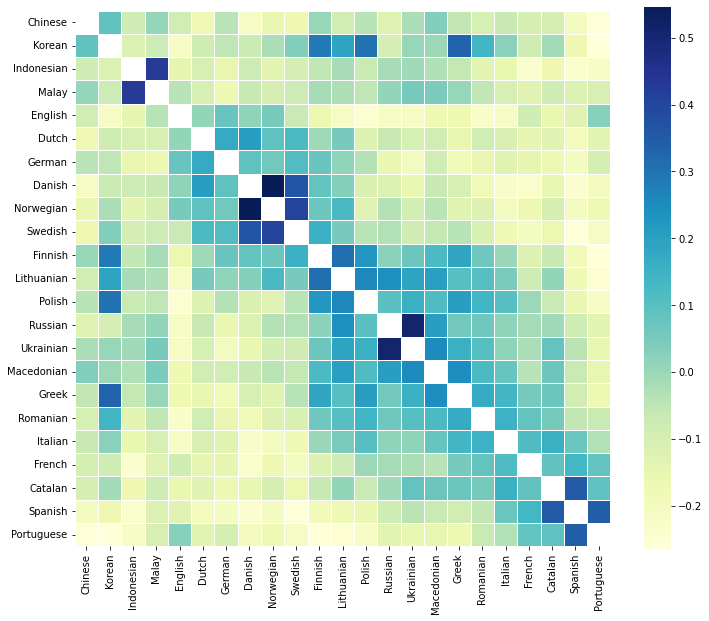

In [11]:
import matplotlib.patches as mpatches
import seaborn as sns
lang_ticks = [language_names[lang] for lang in languages]
fig, ax = plt.subplots(1, 1, sharey=False)

fig.set_figheight(10)
fig.set_figwidth(12)

value_mtx = np.array([[rank_correlation_by_language[lang][lang2] for lang2 in languages] for lang in languages])
mask_mtx = np.array([[True if lang==lang2 else False for lang2 in languages] for lang in languages])
ax = sns.heatmap(value_mtx, linewidths=.5, xticklabels=lang_ticks, yticklabels=lang_ticks, square=True, ax=ax, fmt='g', cmap="YlGnBu", mask=mask_mtx)

plt.show()


#### Error Analysis

In [498]:
for lang, keywords in internal_keywords.items():
    print(f"{lang}: {[kw  for kw in keywords if clf_ranks['bayesian'][lang][kw] >= 12 ]}")

id: []
ms: []
fr: ['soul', 'pray']
es: []
pt: ['suburb', 'suburban']
nl: []
en: ['rational', 'opinion', 'tolerance', 'economy', 'commitment', 'impartial', 'dialogue', 'happiness', 'language', 'emotion', 'empirical', 'reality', 'freedom', 'communication', 'country', 'information', 'polite', 'efficiency', 'tolerant', 'spirit', 'understand', 'autonomy', 'behaviour', 'request', 'soul', 'deadline', 'culture']
ru: ['long']
zh: ['cool', 'heart']
